<a href="https://colab.research.google.com/github/phytometrics/plant_phenotyping_python/blob/dev/notebooks/plantvilllage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 病害虫画像識別モデルの訓練と評価

<center><img src=https://cdn.jsdelivr.net/gh/phytometrics/plant_phenotyping_python@main/assets/0cbf669e881d676a94e4b0add056c21cd505b7ac1e9985317691e65c715d91ad.png width=50%)>

PlantVillage収録画像</center>


## ライセンス

- Mohanty, S. P., Hughes, D. P., & Salathé, M. (2016). Using Deep Learning for Image-Based Plant Disease Detection. Frontiers in Plant Science, 7, 1419. https://doi.org/10.3389/fpls.2016.01419
    - CC-BY

- データセット (https://github.com/spMohanty/PlantVillage-Dataset)
    - データセット権利保持者より、CC-BY4.0相当のライセンスとして取り扱うことの許諾を得ています。(2018/10/29 Dr. Mohanty, Personal Communication.)
- 本稿プログラムコード
    - CC-BY-NC


## 解説
PlantVillage Dataset<sup>1</sup>は、14作物、26種類の病気に罹患した葉の画像を54306枚集めたデータセットです。このようなデータセットを作成・利用して、病気識別にCNNが極めて有効に使えると（歴史上おそらく）初めて実証されました<sup>2</sup>。本稿では、PlantVillageデータセットの一部（トマトの葉のみ）を利用して、同様に識別モデルの訓練を行います。

## 環境構築・データ準備

In [1]:
import os  # ファイルやディレクトリ情報取得・操作など
import pandas as pd  # データフレーム
import tensorflow as tf  # 深層学習
from skimage.io import imread  # 画像操作
import matplotlib.pyplot as plt  # 画像・グラフ表示
import datetime  #日付時間管理

In [2]:
# PlantVillageデータセットをダウンロードします。
!git clone https://github.com/spMohanty/PlantVillage-Dataset.git >/dev/null 2>&1

In [3]:
# 使用するデータセットのパス
DATASET_DIR = "PlantVillage-Dataset/raw/color"

colorフォルダの中に病気の名前がついたフォルダと、さらにその中に該当する病気の写真が格納されています。

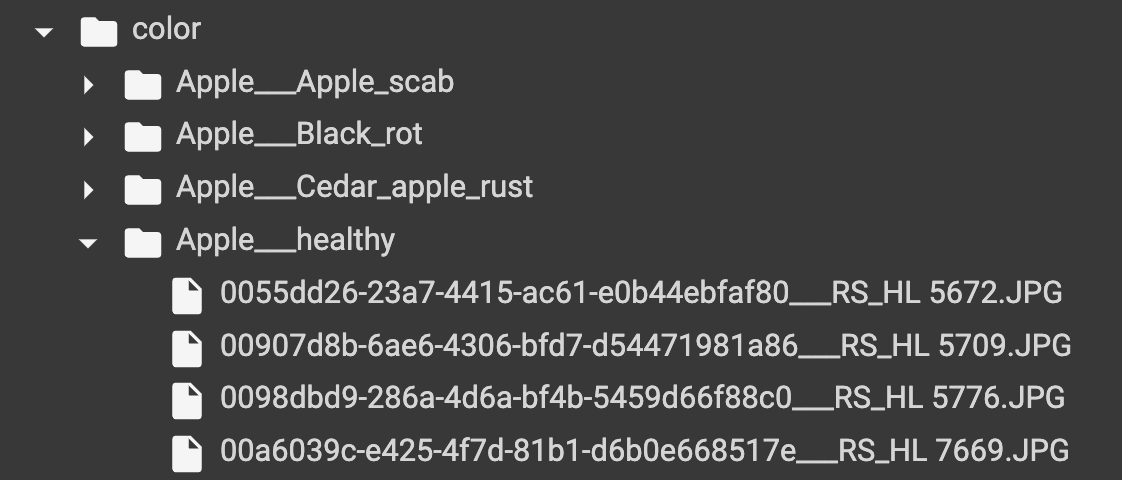

今回はトマト画像のみ取り扱うこととします。

In [4]:
# os.listdirを用いてフォルダ名一覧を取得し、
# "Tomato"を含むフォルダ名のみをリスト内包表記（list comprehension）でフィルタリングします。
folders = [x for x in os.listdir(DATASET_DIR) if x.find("Tomato")>=0]

# 結果確認
for i, folder in enumerate(folders):
    print(i, folder)

0 Tomato___Leaf_Mold
1 Tomato___Septoria_leaf_spot
2 Tomato___healthy
3 Tomato___Early_blight
4 Tomato___Bacterial_spot
5 Tomato___Target_Spot
6 Tomato___Tomato_mosaic_virus
7 Tomato___Tomato_Yellow_Leaf_Curl_Virus
8 Tomato___Late_blight
9 Tomato___Spider_mites Two-spotted_spider_mite


画像の解像度を確認してみましょう。

In [5]:
folder = folders[0]
files = os.listdir(os.path.join(DATASET_DIR, folder))
file = files[0]
path = os.path.join(DATASET_DIR, folder, file)
image = imread(path)
print(image.shape)
print(image.dtype)

(256, 256, 3)
uint8


上の出力結果は、（縦px、横px、色次元数）を表しており、
縦横256px、RGB３色、dtype uint8 (0-255)の画像であることを意味しています。
scikit-imageのimreadを使用しているため、色チャンネルはRGBの順番ですが、opencvを使用した場合、BGRとなることに注意しましょう。

## 教師データの読み込み

kerasでは訓練データの読み込み方法が複数ありますが、ここでは、フォルダ構造から画像とラベルを読み取りデータフレームに格納し、tf.keras.ImageDataGeneratorを使用して訓練に供試しましょう。

In [6]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.model_selection import train_test_split

In [7]:
data = []

for folder in folders:
    files = os.listdir(os.path.join(DATASET_DIR, folder))
    for file in files:
        # DATASET_DIRから見た相対パスなので、DATASET_DIR自体は含めないことに注意。
        file_path = os.path.join(folder, file)
        # 例えばフォルダ名がTomato___Tomato_mosaic_virusの場合、___の後半をラベル名として採用する
        name = folder.split("___")[1]
        data.append({'filename': file_path, 'class': name})  # データを追加

df = pd.DataFrame(data)  # データフレームに変換
df

,filename,class
0,Tomato___Leaf_Mold/559675ba-6f1c-4d85-b66d-849...,Leaf_Mold
1,Tomato___Leaf_Mold/7a8f225e-a87c-47ca-a49d-27b...,Leaf_Mold
2,Tomato___Leaf_Mold/ad0bafb5-fc74-49b6-9626-4c2...,Leaf_Mold
3,Tomato___Leaf_Mold/91eeb305-5a5f-4e72-8258-776...,Leaf_Mold
4,Tomato___Leaf_Mold/b66c322b-7fc4-4d0a-9e57-afe...,Leaf_Mold
...,...,...
18155,Tomato___Spider_mites Two-spotted_spider_mite/...,Spider_mites Two-spotted_spider_mite
18156,Tomato___Spider_mites Two-spotted_spider_mite/...,Spider_mites Two-spotted_spider_mite
18157,Tomato___Spider_mites Two-spotted_spider_mite/...,Spider_mites Two-spotted_spider_mite
18158,Tomato___Spider_mites Two-spotted_spider_mite/...,Spider_mites Two-spotted_spider_mite


In [8]:
# train_test_splitを使用してデータを分割します。
# random_stateは分割後の結果を固定化するため、
# stratifyは分割して作成したサブセット間でクラスラベル数に偏りを生じさせないために指定します。
train_df, temp_df = train_test_split(df, train_size=0.8, random_state=0, stratify=df["class"].values)
val_df, test_df = train_test_split(temp_df, train_size=0.5, random_state=0, stratify=temp_df["class"].values)

In [9]:
# データ数
print(len(train_df), len(val_df), len(test_df))

14528 1816 1816


In [10]:
# それぞれのサブセットに含まれるクラス数を表示します。
# 偏りがないことを確認しましょう。
print(train_df["class"].value_counts())
print("_______")
print(val_df["class"].value_counts())
print("_______")
print(test_df["class"].value_counts())

Tomato_Yellow_Leaf_Curl_Virus           4286
Bacterial_spot                          1702
Late_blight                             1527
Septoria_leaf_spot                      1417
Spider_mites Two-spotted_spider_mite    1341
healthy                                 1273
Target_Spot                             1123
Early_blight                             800
Leaf_Mold                                761
Tomato_mosaic_virus                      298
Name: class, dtype: int64
_______
Tomato_Yellow_Leaf_Curl_Virus           535
Bacterial_spot                          212
Late_blight                             191
Septoria_leaf_spot                      177
Spider_mites Two-spotted_spider_mite    168
healthy                                 159
Target_Spot                             140
Early_blight                            100
Leaf_Mold                                96
Tomato_mosaic_virus                      38
Name: class, dtype: int64
_______
Tomato_Yellow_Leaf_Curl_Virus           53

In [12]:
IMAGE_SIZE = 64

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.
    )
val_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.
    )

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=DATASET_DIR,
    x_col='filename',
    y_col='class',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode='categorical',
    batch_size=32
    )

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    directory=DATASET_DIR,
    x_col='filename',
    y_col='class',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode='categorical',
    batch_size=1
    )

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    directory=DATASET_DIR,
    x_col='filename',
    y_col='class',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode='categorical',
    batch_size=1,
    shuffle=False
    )

Found 14528 validated image filenames belonging to 10 classes.
Found 1816 validated image filenames belonging to 10 classes.
Found 1816 validated image filenames belonging to 10 classes.


In [13]:
train_generator.class_indices

{'Bacterial_spot': 0,
 'Early_blight': 1,
 'Late_blight': 2,
 'Leaf_Mold': 3,
 'Septoria_leaf_spot': 4,
 'Spider_mites Two-spotted_spider_mite': 5,
 'Target_Spot': 6,
 'Tomato_Yellow_Leaf_Curl_Virus': 7,
 'Tomato_mosaic_virus': 8,
 'healthy': 9}

batch: 0


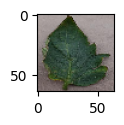

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
____
batch: 1


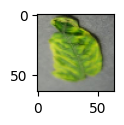

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
____


In [41]:
import matplotlib.pyplot as plt
for i in range(2):  # Change this to see more or fewer batches
    print(f"batch: {i}")
    batch = next(val_generator)
    images, labels = batch
    plt.figure(figsize=(1,1))
    plt.imshow(images[0])
    plt.show()
    print(labels[0])
    print("____")

val_generator.reset()


## CNNモデルの構築

tensorflow kerasではモデル構造を構築（定義）する方法がいくつかありますが、今回は初心者にも理解しやすいSequentialモデルを紹介します。レイヤーを積み重ねるイメージでモデルを構築します。

In [47]:
import tensorflow as tf
tf.keras.backend.clear_session()

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, BatchNormalization

model = Sequential([
    # Block 1
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3), name='block1_conv1'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2'),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'),

    # Block 2
    Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2'),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'),

    # Block 3
    Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3'),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'),

    # Block 4
    Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1'),
    BatchNormalization(),
    Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2'),
    BatchNormalization(),
    Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3'),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'),

    # Block 5
    Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1'),
    BatchNormalization(),
    Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2'),
    BatchNormalization(),
    Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3'),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool'),
    
    GlobalAveragePooling2D(name="GlobalAveragePooling2D"),
    
    # Classification block
    Dense(512, activation='relu', name='fc1'),
    BatchNormalization(),
    Dense(512, activation='relu', name='fc2'),
    BatchNormalization(),
    Dense(10, activation='softmax', name='predictions')
])

# モデルの最適化アルゴリズム・損失関数・関数・尺度などを定義してコンパイルします。

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [43]:
# 構築したモデルのレイヤーやパラメーター数の確認
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 16, 16, 256)       2

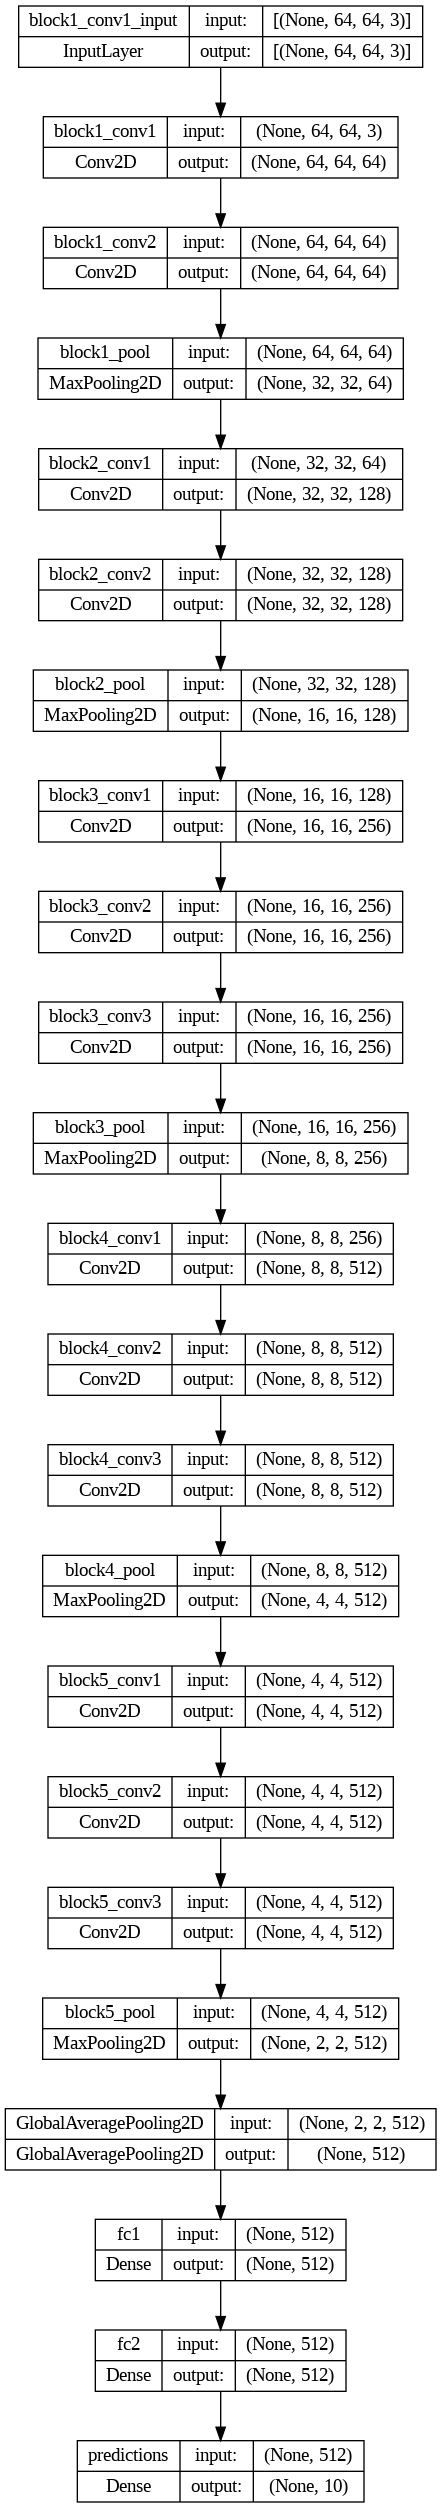

In [44]:
# モデル図を生成させることもできます。
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='vgg16_model.png', show_shapes=True, show_layer_names=True)


## 訓練

In [48]:
es = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
ckpt = tf.keras.callbacks.ModelCheckpoint("scratch_best_weights.hdf5", monitor = 'val_loss',
                                          verbose = 1, save_best_only = True, save_weights_only = True)
scratch_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[es, ckpt],
)

Epoch 1/100
454/454 [==============================] - ETA: 0s - loss: 0.9803 - accuracy: 0.6780
Epoch 1: val_loss improved from inf to 5.77954, saving model to scratch_best_weights.hdf5
454/454 [==============================] - 51s 93ms/step - loss: 0.9803 - accuracy: 0.6780 - val_loss: 5.7795 - val_accuracy: 0.1107
Epoch 2/100
454/454 [==============================] - ETA: 0s - loss: 0.5834 - accuracy: 0.7981
Epoch 2: val_loss improved from 5.77954 to 3.62372, saving model to scratch_best_weights.hdf5
454/454 [==============================] - 50s 111ms/step - loss: 0.5834 - accuracy: 0.7981 - val_loss: 3.6237 - val_accuracy: 0.4510
Epoch 3/100
454/454 [==============================] - ETA: 0s - loss: 0.5009 - accuracy: 0.8301
Epoch 3: val_loss improved from 3.62372 to 1.77428, saving model to scratch_best_weights.hdf5
454/454 [==============================] - 50s 110ms/step - loss: 0.5009 - accuracy: 0.8301 - val_loss: 1.7743 - val_accuracy: 0.5650
Epoch 4/100
454/454 [=========

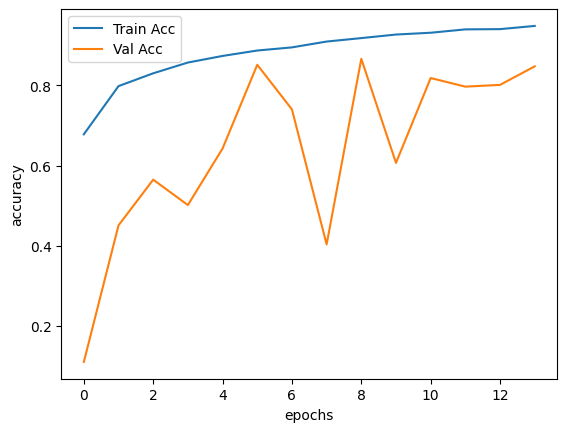

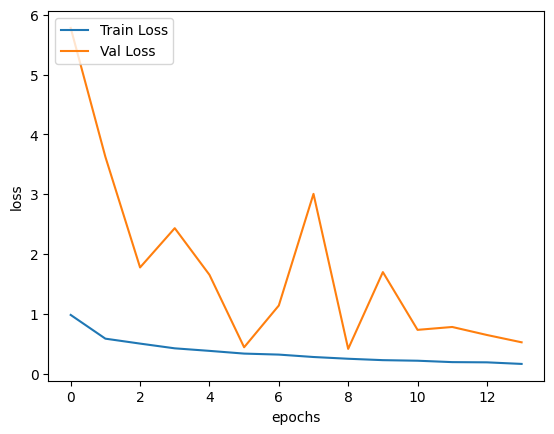

In [51]:
# 訓練履歴を可視化します。
import matplotlib.pyplot as plt

plt.plot(scratch_history.history["accuracy"])
plt.plot(scratch_history.history["val_accuracy"])

plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(['Train Acc', 'Val Acc'], loc='upper left')
plt.show()

plt.plot(scratch_history.history["loss"])
plt.plot(scratch_history.history["val_loss"])

plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(['Train Loss', 'Val Loss'], loc='upper left')


## モデルの性能評価

### 計算準備

In [52]:
y_pred = model.predict(test_generator)

1816/1816 [==============================] - 10s 5ms/step


In [53]:
import numpy as np
y_pred = np.argmax(y_pred,axis=-1)

In [54]:
y_true = test_generator.classes

In [55]:
class_names = list(test_generator.class_indices.keys())

## メトリクス（尺度）計算

モデルの構築(model.compile)時に定義したものに限り、tf.keasのmodelから直接計算することができます。


In [56]:
# モデルのメトリクスの名前
print(model.metrics_names)

# テストデータに対するメトリクスの値
print(model.evaluate(test_generator))

['loss', 'accuracy']
1816/1816 [==============================] - 14s 8ms/step - loss: 0.3949 - accuracy: 0.8574
[0.3949090838432312, 0.8573788404464722]


混同行列（confusion matrix)を表示させてみましょう。

[Text(0.5, 0, 'Bacterial_spot'),
 Text(1.5, 0, 'Early_blight'),
 Text(2.5, 0, 'Late_blight'),
 Text(3.5, 0, 'Leaf_Mold'),
 Text(4.5, 0, 'Septoria_leaf_spot'),
 Text(5.5, 0, 'Spider_mites Two-spotted_spider_mite'),
 Text(6.5, 0, 'Target_Spot'),
 Text(7.5, 0, 'Tomato_Yellow_Leaf_Curl_Virus'),
 Text(8.5, 0, 'Tomato_mosaic_virus'),
 Text(9.5, 0, 'healthy')]

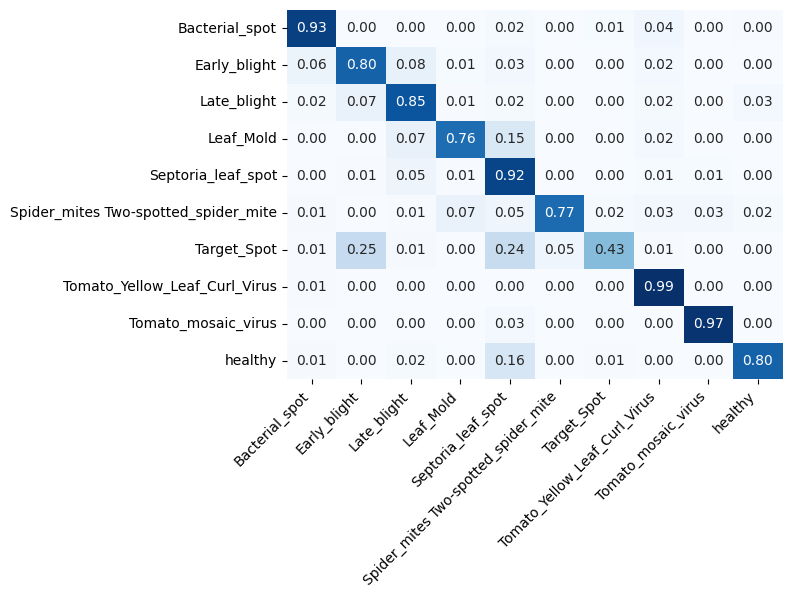

In [57]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

ax = sns.heatmap(
    confusion_matrix(y_true, y_pred, normalize="true"),
    fmt=".2f", cmap='Blues', annot=True, cbar=False,
    xticklabels=class_names,
    yticklabels=class_names
    )
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


## 最後に
今回扱ったデータセットは、各病気の画像それぞれに比較的多くの枚数が確保されており、背景はほぼ均一で、病気間の画像枚数の不均衡が極端ではないという、一般的に"質の良い"ものです。しかし、現実にはこのような状況ではないことが多くあります。その場合、画像の入力サイズといった基本的な検討事項に加え、転移学習（もしくはファインチューニング）やモデルの構造変更、データ拡張、クラス間損失の定義など、さまざまな調整が必要になることに留意してください。

現場データ収集においては、データ量が確保できなかったり、クラス間の画像枚数が揃わなかったり（不均衡）することがあり、効果的なモデルの構築の妨げになります。そのような状況に対応するための各種手法が提案されていますが、それらについては別章で紹介します。